In [2]:

from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from scipy import stats

path = Path(os.getcwd()).parent

%run utils.py

<img src="img/overview.png" width="450">

- Andere kritisieren 
- Entspannt
- Faulheit
- Geschlecht
- Gesellig
- Gruendlich
- Nervoes
- Phantasievoll
- wenig kuenstlerisches Interesse
- Geburtsjahr
- Resilienz*
- Geburtsland*
- Resilienz*

In [3]:
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')

gbs = gbs.fillna(gbs.median())
gesis = gesis.fillna(gesis.median())

In [4]:
gesis.drop(columns = ['GESIS-CODE'], axis=1, inplace = True)
gbs.drop(columns = ['GBS-CODE', 'Gruppe'], axis=1, inplace = True)

drop = ['Personen im Haushalt', 'Druck', 'Optimismus Zukunft', 'Geburtsland', 'Nationalitaet',
       'Familienstand', 'Hoechster Bildungsabschluss', 'Berufliche Ausbildung',
       'Berufsgruppe', 'Leben genießen', 'Zu Nichts aufraffen',
       'Alles anstrengend', 'Zufriedenheit Leben', 'Aktiv', 'Verärgert',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'Nettoeinkommen Selbst', 'Nettoeinkommen Haushalt', 'Schlechter Schlaf',
       'Wahlabsicht', 'Desinteresse Politiker', 'Erwerbstaetigkeit',
       'leicht Vertrauen', 'Wahlteilnahme']

gbs.drop(columns=drop, axis=1, inplace=True)
gesis.drop(columns=drop, axis=1, inplace=True)

non_rep = gbs.copy(deep=True)
rep = gesis.copy(deep=True)

rep['label'] = 'rep'
non_rep['label'] = 'nonrep'

In [5]:
data = pd.concat([rep, non_rep], sort=True).copy(deep=True)
data.reset_index(drop=True, inplace=True)
data['probs'] = len(data.label)*[0]

temperature = 1 
max_drop = 2

ks = []
auc = []

while (len(data[data.label == 'nonrep']) > max_drop):

    rf = RandomForestClassifier(n_estimators=500, 
                                bootstrap=True,
                                max_depth=8,
                                oob_score=True)
    
    probs = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=10,
                              method='predict_proba')
    
    preds = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3)
    
    if preds[0] == 'nonrep' and round(probs[0][0], 0) == 1:
        data['probs'] = [p[1] for p in probs]
    else:
        data['probs'] = [p[0] for p in probs]
    
    drop_id = []
    for _ in range(max_drop):
        softmax = sample(data[data.label == 'nonrep']['probs'], temperature)
        drop = data[data.label == 'nonrep'].iloc[[np.argmax(softmax)]].index[0]
        drop_id.append(drop)

    data.drop(data.index[drop_id], inplace=True)
    data.reset_index(drop=True, inplace=True)

    # EVALUATION
    ks.append(stats.ks_2samp(data[data.label == 'nonrep']['probs'], 
                             data[data.label == 'rep']['probs']))    
    #ks.append(kstest(data.probs, 'uniform'))
    auc.append(metrics.roc_auc_score([1 if k == 'nonrep' else 0 for k in data.label], data.probs))
    #print('length of current GBS subset:', len(data[data.label == 'nonrep'].label))

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-p

In [9]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

subset = [i for i in range(1, len(data[data.label == 'nonrep']['probs']))]
subset

[1]

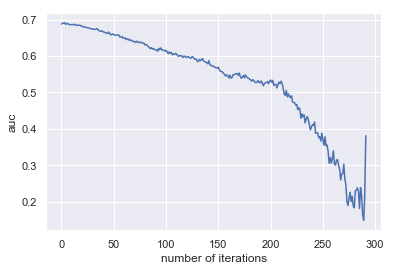

In [22]:
plt.plot(auc)
plt.xlabel("number of iterations")
plt.ylabel('auc')
plt.show()

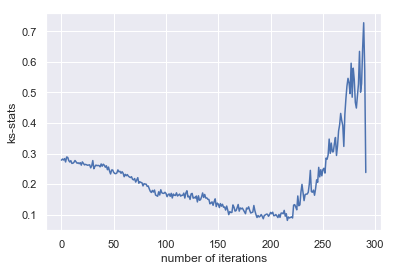

In [20]:
plt.plot([a[0] for a in ks])
plt.ylabel('ks-stats')
plt.xlabel('number of iterations')
plt.show()

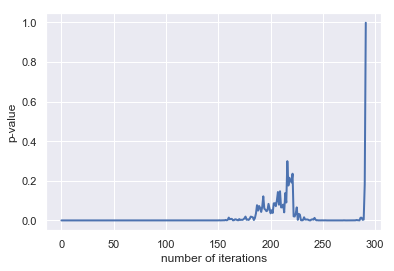

In [19]:
plt.plot([a[1] for a in ks], linewidth=2.0)
plt.ylabel('p-value')#
plt.xlabel('number of iterations')
plt.show()